In [20]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow_hub as hub

In [21]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066',
   extract=True,
   cache_subdir='/content/')

In [22]:
IMAGE_SHAPE = (224, 224)

In [23]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2,horizontal_flip=True, vertical_flip=True)
image_data = image_generator.flow_from_directory(str('/content/Plant_leave_diseases_dataset_without_augmentation'), target_size=IMAGE_SHAPE,subset='training')
val_data = image_generator.flow_from_directory(str('/content/Plant_leave_diseases_dataset_without_augmentation'), target_size=IMAGE_SHAPE,subset='validation')

Found 44371 images belonging to 39 classes.
Found 11077 images belonging to 39 classes.


In [24]:

for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 39)


In [25]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

In [34]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [27]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [30]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(224,224,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [35]:
model = tf.keras.Sequential([
                             data_augmentation,
                             feature_extractor_layer,
                             tf.keras.layers.Dense(image_data.num_classes)])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 39)                49959     
Total params: 2,307,943
Trainable params: 49,959
Non-trainable params: 2,257,984
_________________________________________________________________


In [36]:
predictions = model(image_batch)

In [37]:
predictions.shape

TensorShape([32, 39])

In [38]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [39]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [40]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=10,
                    validation_data=val_data,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/10
1387/1387 [==============================] - 143s 103ms/step - loss: 0.2616 - acc: 0.9062 - val_loss: 0.3169 - val_acc: 0.9011
Epoch 2/10
1387/1387 [==============================] - 136s 98ms/step - loss: 0.3020 - acc: 0.9062 - val_loss: 0.2597 - val_acc: 0.9212
Epoch 3/10
1387/1387 [==============================] - 135s 97ms/step - loss: 0.1751 - acc: 0.9375 - val_loss: 0.2591 - val_acc: 0.9148
Epoch 4/10
1387/1387 [==============================] - 135s 97ms/step - loss: 0.2307 - acc: 0.9375 - val_loss: 0.2531 - val_acc: 0.9157
Epoch 5/10
1387/1387 [==============================] - 134s 97ms/step - loss: 0.2666 - acc: 0.8750 - val_loss: 0.2752 - val_acc: 0.9066
Epoch 6/10
1387/1387 [==============================] - 134s 97ms/step - loss: 0.0525 - acc: 0.9688 - val_loss: 0.2510 - val_acc: 0.9204
Epoch 7/10
1387/1387 [==============================] - 134s 96ms/step - loss: 0.0795 - acc: 0.9688 - val_loss: 0.2553 - val_acc: 0.9202
Epoch 8/10
1387/1387 [==================

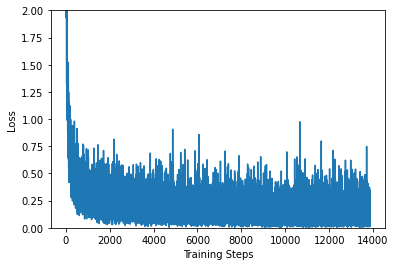

In [41]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

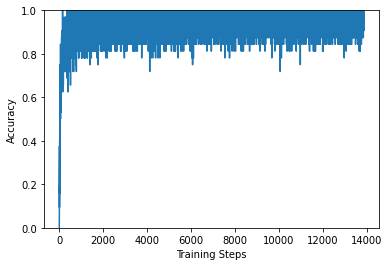

In [42]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [43]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Apple___Apple_Scab', 'Apple___Black_Rot',
       'Apple___Cedar_Apple_Rust', 'Apple___Healthy',
       'Background_Without_Leaves', 'Blueberry___Healthy',
       'Cherry___Powdery_Mildew', 'Cherry___Healthy',
       'Corn___Cercospora_Leaf_Spot Gray_Leaf_Spot', 'Corn___Common_Rust',
       'Corn___Northern_Leaf_Blight', 'Corn___Healthy',
       'Grape___Black_Rot', 'Grape___Esca_(Black_Measles)',
       'Grape___Leaf_Blight_(Isariopsis_Leaf_Spot)', 'Grape___Healthy',
       'Orange___Haunglongbing_(Citrus_Greening)',
       'Peach___Bacterial_Spot', 'Peach___Healthy',
       'Pepper,_Bell___Bacterial_Spot', 'Pepper,_Bell___Healthy',
       'Potato___Early_Blight', 'Potato___Late_Blight',
       'Potato___Healthy', 'Raspberry___Healthy', 'Soybean___Healthy',
       'Squash___Powdery_Mildew', 'Strawberry___Leaf_Scorch',
       'Strawberry___Healthy', 'Tomato___Bacterial_Spot',
       'Tomato___Early_Blight', 'Tomato___Late_Blight',
       'Tomato___Leaf_Mold', 'Tomato___Septoria_

In [44]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [45]:
image_batch.shape

(32, 224, 224, 3)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


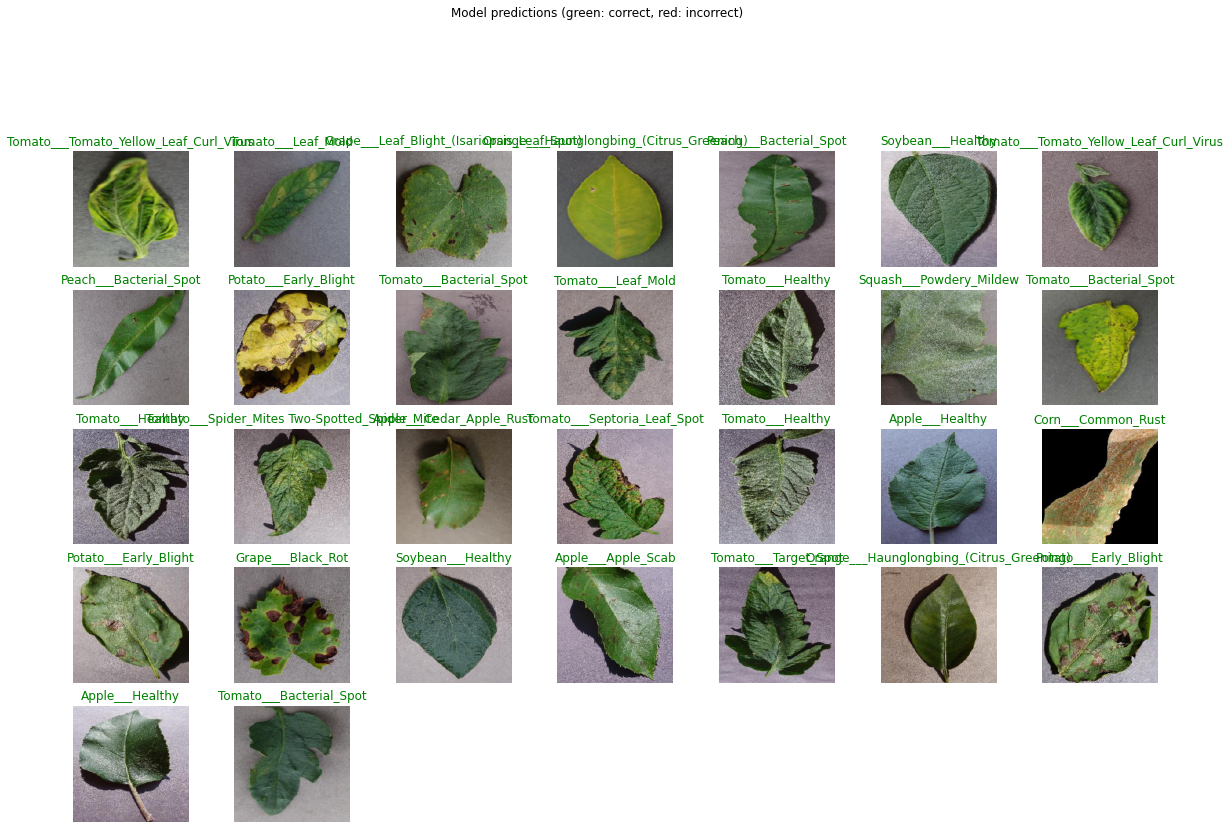

In [47]:
label_id = np.argmax(label_batch, axis=-1)
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.2,wspace=0.1)
for n in range(30):
  plt.subplot(8,7,n+1)
  plt.imshow(image_batch[n])
  image_batch[n].shape
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
  print(image_batch[n].shape)

  
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [51]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

/content/3.JPG
Category
['Tomato___Late_Blight']


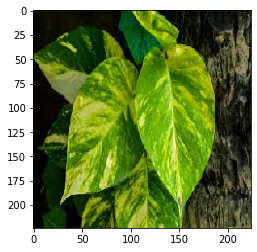

In [50]:
testimage='3.JPG'

data_dir = pathlib.Path('/content/')
data_dir = os.path.join(data_dir, testimage)
print (data_dir)
img = keras.preprocessing.image.load_img(
  data_dir, target_size=(224, 224)
)
img_array = np.array(img)/255.0
plt.imshow(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
# imgplot = plt.imshow(img_array)
img_array.shape
predictions = model.predict(img_array)

predicted_id = np.argmax(predictions, axis=-1)

predicted_label_batch = class_names[predicted_id]
print("Category")
print(predicted_label_batch)
# print("Confidence")
# print( np.max(predictions))

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(predicted_label_batch, 100 * np.max(score))
# )
# plt.imshow(img)

In [ ]:
testimage='2.jpg'
plantprediction(testimage)